Plotting a UnitIntervalMesh:


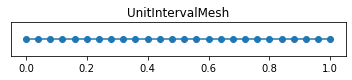

In [1]:
from dolfin import *
import numpy as np
parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

# Define mesh
N_mesh = 25
mesh = UnitIntervalMesh(N_mesh)
#mesh = RectangleMesh(Point(0., 0.), Point(1., 0.1), 50, 5)

print("Plotting a UnitIntervalMesh:")
plt.figure()
plot(mesh, title="UnitIntervalMesh")

tol = 1E-12
# Sub domain for clamp at left end
def left(x, on_boundary):
    return near(x[0], 0.,tol) and on_boundary

# Sub domain for rotation at right end
def right(x, on_boundary):
    return near(x[0], 1.,tol) and on_boundary

def left_and_right(x, on_boundary):
    return on_boundary

# Set up boundary domains

In [2]:
# Create mesh function over the cell facets
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(right)
force_boundary.mark(boundary_subdomains, 3)

# Define measure for boundary condition integral
dss = ds(subdomain_data=boundary_subdomains)

In [3]:
E = Constant(70e3)
nu = Constant(0.3)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
sig0 = Constant((0.1e-6))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus
rho = Constant(10e4)

Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 1000
load_steps = np.linspace(0, 1, Nincr+1)[1:]

dt = Constant(load_steps[1]-load_steps[0])
dt_ = float(dt)

# Newmark-beta method
betaN = Constant(0.25)
gammaN = Constant(0.5)

In [4]:
float(betaN), float(dt), float(sqrt(2*mu/rho))

(0.25, 0.001, 0.7337993857053428)

In [5]:
deg_u = 2
deg_stress = 2
V = FunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=1, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)
# Define function space for stresses
Vsig = VectorFunctionSpace(mesh, "DG", 0)

In [6]:
sig = Function(W)
sig_old = Function(W)
beta = Function(W0)
gamma0 = Function(W0)
gamma0.interpolate(Constant(1e-6))
u = Function(V, name="Total displacement")
u_pre = Function(V)
u_old = Function(V)
u_d_old = Function(V)
u_dd_old = Function(V)
du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
u_ = TestFunction(V)

sig_out = Function(Vsig, name="sigma")
eps_out = Function(Vsig, name="epsilon")

In [7]:
# Set up boundary condition at left end
bc_expression = Expression( ("t <= tc ? x[0]*1e-6*t : 0.5e-6"), tc=0.5, t=0, degree=2) # Constant(0.0)
bc = DirichletBC(V, bc_expression, left_and_right)

zero = Constant(0.0)
bc_newton = DirichletBC(V, zero, left_and_right)

# bc = [DirichletBC(V.sub(1), 0, facets, 1), DirichletBC(V.sub(0), 0, facets, 3)]
n = FacetNormal(mesh)

q_lim = float(2/sqrt(3)*sig0*mu*2)
# loading = Expression("q*t", q=q_lim, t=0, degree=2)
loading = Expression(("t <= tc ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=1.2, degree=2)

# DEFINING SOURCE TERM
# source = Expression(("t <= tc && x[0]<0.55 && x[0]>0.45  ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=1.2, degree=2)
source = Constant(0.0)

def F_ext(v):
    return dot(loading,v)*dss(3)
    # return loading*dot(n, v)*dss(3)

In [8]:
# Update formula for acceleration
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
def update_a(u, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        betaN_ = betaN
    else:
        dt_ = float(dt)
        betaN_ = float(betaN)
    return (u-u_old-dt_*v_old)/betaN_/dt_**2 - (1-2*betaN_)/2/betaN_*a_old

# Update formula for velocity
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
def update_v(a, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        gamma_ = gammaN
    else:
        dt_ = float(dt)
        gamma_ = float(gammaN)
    return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

def update_fields(u, u_old, v_old, a_old):
    """Update fields at the end of each time step."""

    # Get vectors (references)
    u_vec, u0_vec  = u.vector(), u_old.vector()
    v0_vec, a0_vec = v_old.vector(), a_old.vector()

    # use update functions using vector arguments
    a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

    # Update (u_old <- u)
    v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
    u_old.vector()[:] = u.vector()

In [9]:
def eps(v):
    e = 0.5*grad(v)
    return e

def sigma(eps_el):
    return 2*mu*eps_el

def sigma_out(r):
    return 2.0*mu*sym(grad(r))

In [10]:
def proj_sig(old_u,old_sig,old_Du):
    eps_old = eps(old_u)
    beta = sig0/(abs(eps_old[0])+sig0)
    beta = 1
    # beta = gamma0
    # beta /= (eps_old[0]+as_tensor(gamma0[0]))
    return 2*mu*beta*eps(old_Du)+old_sig, beta


In [11]:
def sigma_tang(e):
    return 2*mu*beta*e

In [12]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

# a_Newton = inner(eps(v), sigma_tang(eps(u_)))*dxm

# a_Newton = inner(eps(u_), sigma_tang(eps(v)))*dxm

a_Newton = rho*inner(u_,v)/(betaN*dt*dt)*dxm + inner(eps(u_), sigma_tang(eps(v)) )*dxm
# F_ext(u_) + \
res = (-rho)*inner(u_,u)/(betaN*dt*dt)*dxm + \
      -inner(eps(u_), sig)*dxm + \
      F_ext(u_) + \
      dot(u_,source)*dxm + \
      rho*inner(u_old+dt*u_d_old,u_)*1./(betaN*dt*dt)*dxm + \
      (1.-2*betaN)/(2*betaN)*rho*inner(u_dd_old,u_)*dxm

In [13]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dxm
    b_proj = inner(v, v_)*dxm
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [14]:
file_results = XDMFFile("nonlinearElas1DVeri__results.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

In [15]:
sig_out.ufl_shape

(1,)

In [16]:
results = np.zeros((Nincr+1, 5))
results_1d = np.zeros((Nincr+1, N_mesh))

# Initial conditions
u_old.interpolate( Expression(("0"), degree=2) )
u_d_old.interpolate( Expression(("0"), degree=2) )
# u.assign(u_old)

for (i, t) in enumerate(load_steps):
    loading.t = t
    bc_expression.t = t
    # source.t = t
    bc.apply(u.vector())
    
    sig_, beta_ = proj_sig(u,sig_old,Du)
    local_project(sig_, W, sig)
    local_project(beta_, W0, beta)
    A, Res = assemble_system(a_Newton, res, bc_newton)
    nRes0 = Res.norm("l2")
    nRes = nRes0
    Du.interpolate(Constant(0))
    print("Increment:", str(i+1),"   Initial Residual:", nRes0)
    niter = 0
    u_pre.assign(u)
    while (nRes/nRes0 > tol and nRes0>1e-16) and niter < Nitermax:
        solve(A, du.vector(), Res, "mumps")
        Du.assign(Du+du)
        u.assign(u+du) # u^{k+1}_{n+1}
        sig_, beta_ = proj_sig(u_pre,sig_old,Du)
        local_project(sig_, W, sig)
        local_project(beta_, W0, beta)
        A, Res = assemble_system(a_Newton, res, bc_newton)
        nRes = Res.norm("l2")
        print("    Residual:", nRes," ",niter)
        niter += 1
    u.assign(u_pre+Du)
    
    update_fields(u, u_old, u_d_old, u_dd_old)
    
    sig_old.assign(sig)
    
# ----------------
# Post-processing
# ----------------
#
# Inside the incremental loop, the displacement and plastic strains are exported
# at each time increment, the plastic strain must first be projected onto the
# previously defined DG FunctionSpace. We also monitor the value of the cylinder
# displacement on the inner boundary. The load-displacement curve is then plotted::

    local_project(sig, Vsig, sig_out)
    local_project(eps(u), Vsig, eps_out)
    
    file_results.write(u, t)
    for i_x in range(N_mesh):
        results_1d[i+1,i_x] = u(i_x/(N_mesh-1))
    tc = 0.7;
    if t<tc:
        # results[i+1, :] = (u(1),t,4*t*(1-t))
        results[i+1, :] = (u(1), sig_out(1),t,4*t*(1-t),eps_out(1))
    else:
        results[i+1, :] = (u(1), sig_out(1),t,0,eps_out(1))


Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.


/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()
/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/quadrature/quadraturerepresentation.py:58: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


Increment: 1    Initial Residual: 1.9876159799998157
    Residual: 1.4707836392670892e-15   0
Increment: 2    Initial Residual: 1.975072879658674
    Residual: 0.00943051804642675   0
    Residual: 2.3751297648980473e-15   1
Increment: 3    Initial Residual: 1.9570182443091966
    Residual: 0.006047896732742526   0
    Residual: 3.329743759487874e-15   1
Increment: 4    Initial Residual: 1.9320701554582391
    Residual: 0.005773498082282827   0
    Residual: 2.554719435777531e-15   1
Increment: 5    Initial Residual: 1.9010949943744997
    Residual: 0.0083323619516772   0
    Residual: 2.487958770008172e-15   1
Increment: 6    Initial Residual: 1.8657071902612008
    Residual: 0.007336285321898034   0
    Residual: 3.361978235744516e-15   1
Increment: 7    Initial Residual: 1.827293479379496
    Residual: 0.004070734255656377   0
    Residual: 2.124706989126661e-15   1
Increment: 8    Initial Residual: 1.7858183094085585
    Residual: 0.006568938608914403   0
    Residual: 6.7450046344

Increment: 81    Initial Residual: 1.4129906949490065
    Residual: 0.008701372220775645   0
    Residual: 1.5358040586646544e-14   1
Increment: 82    Initial Residual: 1.4163030299706783
    Residual: 0.0083021173680243   0
    Residual: 7.640399661428378e-15   1
Increment: 83    Initial Residual: 1.421836094983331
    Residual: 0.0045425770438731645   0
    Residual: 6.956200681856215e-14   1
Increment: 84    Initial Residual: 1.4288812107885682
    Residual: 0.005399086015118885   0
    Residual: 2.8380045529044753e-14   1
Increment: 85    Initial Residual: 1.4358375747362935
    Residual: 0.008339473867404192   0
    Residual: 2.4963976348422528e-14   1
Increment: 86    Initial Residual: 1.4419935267922883
    Residual: 0.007345032272678091   0
    Residual: 8.881784197001252e-15   1
Increment: 87    Initial Residual: 1.4463914176317225
    Residual: 0.004950284699508512   0
    Residual: 2.5680492922932105e-14   1
Increment: 88    Initial Residual: 1.4469669675651156
    Residual:

Increment: 157    Initial Residual: 1.3041684028809695
    Residual: 0.007945999060328873   0
    Residual: 4.6593403086362175e-14   1
Increment: 158    Initial Residual: 1.3042755007475513
    Residual: 0.007746418502649186   0
    Residual: 1.7763568394002505e-14   1
Increment: 159    Initial Residual: 1.3068574835597748
    Residual: 0.004179651400929022   0
    Residual: 4.2298185930855886e-14   1
Increment: 160    Initial Residual: 1.310361731562204
    Residual: 0.005598274787069738   0
    Residual: 1.9860273225978185e-14   1
Increment: 161    Initial Residual: 1.3126157922999588
    Residual: 0.009152803475779235   0
    Residual: 1.5688358818848954e-14   1
Increment: 162    Initial Residual: 1.3137361888673538
    Residual: 0.008621421356933412   0
    Residual: 5.2123286135672266e-14   1
Increment: 163    Initial Residual: 1.3150699519527986
    Residual: 0.005403684312717712   0
    Residual: 6.407208558155529e-14   1
Increment: 164    Initial Residual: 1.3169160760271517
  

    Residual: 3.784932501222918e-14   1
Increment: 221    Initial Residual: 1.3241978854085916
    Residual: 0.006632392346918558   0
    Residual: 4.372869577583732e-14   1
Increment: 222    Initial Residual: 1.320407738139476
    Residual: 0.00867888108251024   0
    Residual: 6.738459297533929e-14   1
Increment: 223    Initial Residual: 1.3191776564570494
    Residual: 0.006744565872006366   0
    Residual: 3.936143820865883e-14   1
Increment: 224    Initial Residual: 1.3218464805856576
    Residual: 0.00219470025404266   0
    Residual: 8.350766672679668e-14   1
Increment: 225    Initial Residual: 1.326780644285532
    Residual: 0.006079093630927511   0
    Residual: 7.180525660788723e-14   1
Increment: 226    Initial Residual: 1.3318003745943747
    Residual: 0.008947769579307725   0
    Residual: 2.3024216127992717e-14   1
Increment: 227    Initial Residual: 1.3363246402384314
    Residual: 0.007445057487134378   0
    Residual: 4.6525630827818513e-14   1
Increment: 228    Initia

Increment: 288    Initial Residual: 1.4093311816235192
    Residual: 0.0061784731058633765   0
    Residual: 1.2772487431965053e-13   1
Increment: 289    Initial Residual: 1.4065252300707318
    Residual: 0.0034763809223305048   0
    Residual: 2.8198790620570592e-14   1
Increment: 290    Initial Residual: 1.4022443340347135
    Residual: 0.007433262582578038   0
    Residual: 5.188056869979446e-14   1
Increment: 291    Initial Residual: 1.3957668426539815
    Residual: 0.00879824090233349   0
    Residual: 1.422306192543913e-13   1
Increment: 292    Initial Residual: 1.3876042495543444
    Residual: 0.006456945174666769   0
    Residual: 1.1111818432875547e-13   1
Increment: 293    Initial Residual: 1.377766689390135
    Residual: 0.006089525303956403   0
    Residual: 1.0178075165453597e-13   1
Increment: 294    Initial Residual: 1.3661909561329582
    Residual: 0.008841348798385941   0
    Residual: 5.756054031998179e-14   1
Increment: 295    Initial Residual: 1.3547924591539138
   

Increment: 376    Initial Residual: 1.3257878939655767
    Residual: 0.003925241851123179   0
    Residual: 7.184918763469982e-14   1
Increment: 377    Initial Residual: 1.331661580028018
    Residual: 0.005320939750274381   0
    Residual: 9.291551940735602e-14   1
Increment: 378    Initial Residual: 1.3366909602364234
    Residual: 0.00873685896132814   0
    Residual: 2.7974095480984613e-14   1
Increment: 379    Initial Residual: 1.3405102221451866
    Residual: 0.008070536770673674   0
    Residual: 9.979268544091823e-14   1
Increment: 380    Initial Residual: 1.3433717216198149
    Residual: 0.005648503241306962   0
    Residual: 2.1572316176247263e-13   1
Increment: 381    Initial Residual: 1.3448638479643171
    Residual: 0.007527974623760999   0
    Residual: 3.03543989777123e-14   1
Increment: 382    Initial Residual: 1.345659492253167
    Residual: 0.009147772388770514   0
    Residual: 9.071602374038224e-14   1
Increment: 383    Initial Residual: 1.3482726007687924
    Resid

    Residual: 8.760159180054893e-14   1
Increment: 467    Initial Residual: 1.375100661241743
    Residual: 0.006664569307242321   0
    Residual: 3.793260195561498e-14   1
Increment: 468    Initial Residual: 1.3816361641094237
    Residual: 0.00592018938576508   0
    Residual: 3.692088357856443e-14   1
Increment: 469    Initial Residual: 1.3868404365103673
    Residual: 0.008617162662675832   0
    Residual: 1.3159435622932943e-13   1
Increment: 470    Initial Residual: 1.391979495055519
    Residual: 0.008311870150099217   0
    Residual: 7.677479198155733e-14   1
Increment: 471    Initial Residual: 1.3988485216585012
    Residual: 0.004100761868581159   0
    Residual: 8.20207644424556e-14   1
Increment: 472    Initial Residual: 1.4069537180320504
    Residual: 0.004397386565517806   0
    Residual: 6.355287432313019e-14   1
Increment: 473    Initial Residual: 1.414295371435062
    Residual: 0.008350121072440016   0
    Residual: 4.9483575555996563e-14   1
Increment: 474    Initial

    Residual: 3.749942721349417e-12   1
Increment: 549    Initial Residual: 55.020539154947265
    Residual: 2.9618147730660183   0
    Residual: 3.2475456594251457e-12   1
Increment: 550    Initial Residual: 52.16458447261951
    Residual: 3.0879293506997807   0
    Residual: 3.804689306589696e-12   1
Increment: 551    Initial Residual: 51.032222733710135
    Residual: 1.4391413832850637   0
    Residual: 3.6662903532026344e-12   1
Increment: 552    Initial Residual: 51.313154791532284
    Residual: 1.4617118103550109   0
    Residual: 3.938227581713539e-12   1
Increment: 553    Initial Residual: 49.32214119436072
    Residual: 3.015858451087188   0
    Residual: 3.9118846266513295e-12   1
Increment: 554    Initial Residual: 47.18155001880882
    Residual: 2.7617522087316204   0
    Residual: 3.885363069147175e-12   1
Increment: 555    Initial Residual: 48.65429725404273
    Residual: 0.9992435812393357   0
    Residual: 3.6662903532026344e-12   1
Increment: 556    Initial Residual: 5

    Residual: 0.5745348625592628   0
    Residual: 7.161368443132061e-12   1
Increment: 621    Initial Residual: 54.17246097648024
    Residual: 2.498702218340041   0
    Residual: 5.894199328766136e-12   1
Increment: 622    Initial Residual: 52.06567567635668
    Residual: 3.246061025818905   0
    Residual: 6.7449932313099116e-12   1
Increment: 623    Initial Residual: 50.65356167226165
    Residual: 2.061540128550357   0
    Residual: 7.71731845292249e-12   1
Increment: 624    Initial Residual: 51.46095357324918
    Residual: 0.9630302304523232   0
    Residual: 5.752149554916067e-12   1
Increment: 625    Initial Residual: 50.462117989017536
    Residual: 2.7215099113751022   0
    Residual: 7.609378613179393e-12   1
Increment: 626    Initial Residual: 47.72206560455202
    Residual: 3.0517026014374005   0
    Residual: 7.71731845292249e-12   1
Increment: 627    Initial Residual: 47.83310229660163
    Residual: 1.550425918013489   0
    Residual: 7.044915666860865e-12   1
Increment:

Increment: 686    Initial Residual: 53.26666384854302
    Residual: 2.8866405959996073   0
    Residual: 1.5647538506605318e-11   1
Increment: 687    Initial Residual: 52.144731768395346
    Residual: 3.046531812926832   0
    Residual: 1.33667876586506e-11   1
Increment: 688    Initial Residual: 52.873943381103814
    Residual: 1.479634491681281   0
    Residual: 1.1788398657532271e-11   1
Increment: 689    Initial Residual: 54.18364950624182
    Residual: 1.5999982189427837   0
    Residual: 1.2470363072499902e-11   1
Increment: 690    Initial Residual: 52.56950261880106
    Residual: 3.067094091647035   0
    Residual: 1.3116919128020487e-11   1
Increment: 691    Initial Residual: 50.581855262645995
    Residual: 2.7465725097546074   0
    Residual: 1.2202151870040997e-11   1
Increment: 692    Initial Residual: 52.10770036955102
    Residual: 0.8367691999345841   0
    Residual: 1.3612070276481759e-11   1
Increment: 693    Initial Residual: 53.56588120363096
    Residual: 1.92199755

    Residual: 1.543463690584498e-11   1
Increment: 755    Initial Residual: 46.58499981499608
    Residual: 3.2320397316932694   0
    Residual: 1.55414522765887e-11   1
Increment: 756    Initial Residual: 44.00428265408308
    Residual: 2.296412906955166   0
    Residual: 1.585758197885543e-11   1
Increment: 757    Initial Residual: 45.79614894103691
    Residual: 0.4687182725918163   0
    Residual: 1.233698637065621e-11   1
Increment: 758    Initial Residual: 46.8006994401505
    Residual: 2.444998274679806   0
    Residual: 1.532707715009812e-11   1
Increment: 759    Initial Residual: 44.741134434059056
    Residual: 3.198915828926638   0
    Residual: 1.3116919128020487e-11   1
Increment: 760    Initial Residual: 44.225734174384876
    Residual: 2.0391157377876405   0
    Residual: 1.543463690584498e-11   1
Increment: 761    Initial Residual: 46.2898156593656
    Residual: 1.0930969144509701   0
    Residual: 1.626953582672133e-11   1
Increment: 762    Initial Residual: 46.3543123

    Residual: 2.1827872842550278e-11   1
Increment: 833    Initial Residual: 56.13976185447376
    Residual: 0.9764487121279628   0
    Residual: 2.1827872842550278e-11   1
Increment: 834    Initial Residual: 56.57964969904754
    Residual: 2.3975477081580814   0
    Residual: 2.0255408754856113e-11   1
Increment: 835    Initial Residual: 53.65701103239245
    Residual: 3.2327595615822786   0
    Residual: 2.4404303740081994e-11   1
Increment: 836    Initial Residual: 52.42059215872132
    Residual: 2.1185760928134134   0
    Residual: 1.925037439697619e-11   1
Increment: 837    Initial Residual: 55.084217604884664
    Residual: 0.44715751510062285   0
    Residual: 2.648488549050132e-11   1
Increment: 838    Initial Residual: 56.90301374197319
    Residual: 2.556207658746938   0
    Residual: 2.271917036850354e-11   1
Increment: 839    Initial Residual: 56.27735585447367
    Residual: 3.1499958527366445   0
    Residual: 1.8550124927397645e-11   1
Increment: 840    Initial Residual: 5

    Residual: 1.8389558680982234   0
    Residual: 3.065415430019624e-11   1
Increment: 907    Initial Residual: 52.27293299499524
    Residual: 3.2039826921684775   0
    Residual: 3.0219321571778255e-11   1
Increment: 908    Initial Residual: 50.034797779094525
    Residual: 2.6967271438302487   0
    Residual: 3.233506292350499e-11   1
Increment: 909    Initial Residual: 51.22442770827105
    Residual: 0.7342130032412781   0
    Residual: 3.412726626137322e-11   1
Increment: 910    Initial Residual: 52.86504665928171
    Residual: 2.0382022090039333   0
    Residual: 2.5204656522966648e-11   1
Increment: 911    Initial Residual: 51.93796387448711
    Residual: 3.16935441138299   0
    Residual: 2.9555079544064796e-11   1
Increment: 912    Initial Residual: 51.65661458388246
    Residual: 2.3641964981767862   0
    Residual: 3.508339709148624e-11   1
Increment: 913    Initial Residual: 53.70409000852558
    Residual: 0.8884480174322661   0
    Residual: 2.8413522799043327e-11   1
Inc

Increment: 975    Initial Residual: 45.204046208830654
    Residual: 2.5822046814241326   0
    Residual: 2.572439484307497e-11   1
Increment: 976    Initial Residual: 42.43639767156402
    Residual: 3.0905452128749222   0
    Residual: 2.648488549050132e-11   1
Increment: 977    Initial Residual: 43.46226725950051
    Residual: 1.7144365611781447   0
    Residual: 2.8413522799043327e-11   1
Increment: 978    Initial Residual: 47.20131827020826
    Residual: 1.1627336191578845   0
    Residual: 3.192313447431706e-11   1
Increment: 979    Initial Residual: 47.66299918593531
    Residual: 2.93993102800445   0
    Residual: 2.648488549050132e-11   1
Increment: 980    Initial Residual: 45.77808692627602
    Residual: 3.0589665011873106   0
    Residual: 3.065415430019624e-11   1
Increment: 981    Initial Residual: 47.11454214413074
    Residual: 1.383576120403598   0
    Residual: 2.977813991264138e-11   1
Increment: 982    Initial Residual: 50.3936402852087
    Residual: 1.438827677150172

In [17]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


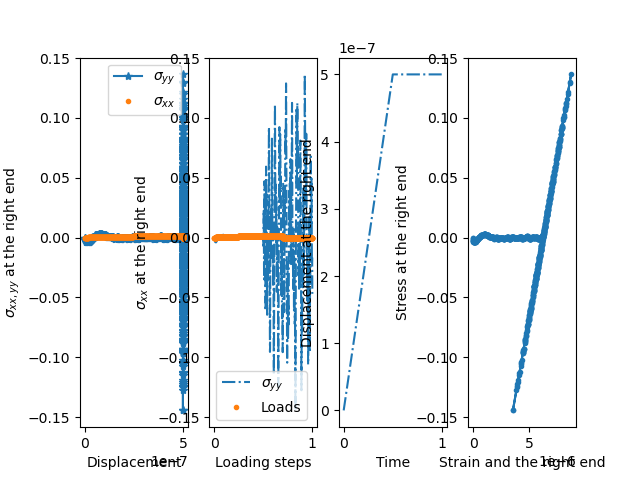

In [18]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.plot(results[:, 0], results[:, 1], "-*")
plt.plot(results[:, 0], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Displacement")
plt.ylabel("$\sigma_{xx,yy}$ at the right end")
plt.legend(["$\sigma_{yy}$","$\sigma_{xx}$","Loads"])
plt.subplot(1,4,2)
plt.plot(results[:, 2], results[:, 1], "-.")
plt.plot(results[:, 2], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Loading steps")
plt.ylabel("$\sigma_{xx}$ at the right end")
plt.legend(["$\sigma_{yy}$","Loads"])
plt.subplot(1,4,3)
plt.plot(results[:, 2], results[:, 0], "-.")
plt.xlabel("Time")
plt.ylabel("Displacement at the right end")
plt.subplot(1,4,4)
N_pt = 1000;
plt.plot(results[:N_pt, 4], results[:N_pt, 1], ".-")
# plt.plot(results[:N_pt, 4], 2*float(mu)*float(sig0)*np.log(1+abs(results[:N_pt, 4])/float(sig0))\
#          *abs(results[:N_pt, 4])/results[:N_pt, 4], "-")
plt.xlabel("Strain and the right end")
plt.ylabel("Stress at the right end")
plt.show()

<IPython.core.display.Javascript object>


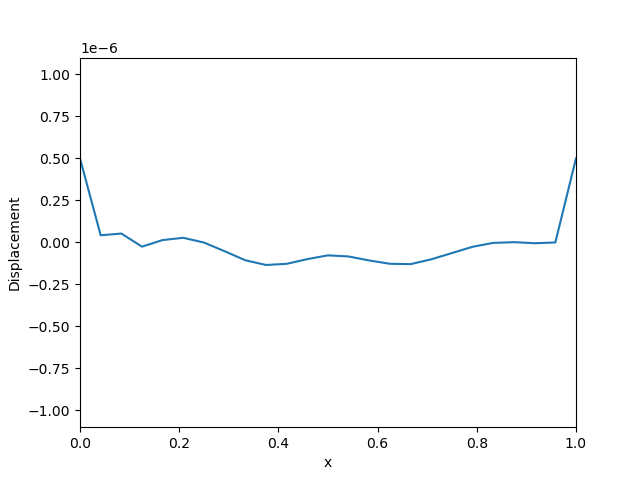

In [19]:
fig, ax = plt.subplots()

line, = ax.plot([])

ax.set_xlim(0,1)
ax.set_ylim(-1.1e-6,1.1e-6)

ax.set_xlabel('x')
ax.set_ylabel('Displacement')

def animate(frame_num):
    # ax.clear()
    line.set_data((np.linspace(0,1,N_mesh), results_1d[frame_num, :]))
    return line

ani = FuncAnimation(fig, animate, frames=Nincr, interval=1)


plt.show()

